# Toxic Comment Classification - LSTM

melakukan analisis data eksplorasi untuk klasifikasi komentar beracun dan membangun model multi-headed yang mampu mendeteksi berbagai jenis toksisitas seperti ancaman, kecabulan, penghinaan, dan kebencian berbasis identitas

Dataset : https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data 

GloVes : https://www.kaggle.com/datasets/incorpes/glove6b200d 

Referensi : https://nlp.stanford.edu/projects/glove/ 

# Siapkan Akun Kredential Kaggle

In [ ]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dan Menyiapkan Dataset

In [ ]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 78% 41.0M/52.6M [00:01<00:00, 28.7MB/s]
100% 52.6M/52.6M [00:01<00:00, 32.1MB/s]


In [ ]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


# Import Package dan Library

In [ ]:
import pandas as pd
import numpy as np

import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.utils import resample

# Lihat Training Dataset

In [ ]:
train_data_or = pd.read_csv('/content/train.csv.zip')
train_data_or.head().append(train_data_or.tail())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


# Lihat Test Dataset

In [ ]:
test_data = pd.read_csv('/content/test.csv.zip')
test_data.head().append(test_data.tail())

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


# Drop Features yang tidak dibutuhkan

In [ ]:
train_data_or.drop(['id'],axis=1,inplace=True)

In [ ]:
test_data.drop(['id'],axis=1,inplace=True)

In [ ]:
# lihat shape of the dataset
train_data_or.shape

(159571, 7)

In [ ]:
x=train_data_or.iloc[:,2:].sum()

#menandai komentar tanpa tag sebagai "clean"
rowsums=train_data_or.iloc[:,2:].sum(axis=1)
train_data_or['clean']=(rowsums==0)

#hitung jumlah entri clean
train_data_or['clean'].sum()
print("Total comments = ",len(train_data_or))
print("Total clean comments = ",train_data_or['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  149012
Total tags = 19804


# Menurunkan Kelas Mayoritas

Kita bisa melihat kelasnya tidak seimbang dan datasetnya sangat besar. Jadi untuk melatih dan menyeimbangkan dataset dengan lebih cepat, kita coba turunkan sampel kelas mayoritas.

In [ ]:
df_majority = train_data_or[train_data_or.clean==True]
df_minority = train_data_or[train_data_or.clean==False]

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=10000,
                                  random_state=123)

train_data = pd.concat([df_majority_downsampled,df_minority])

In [ ]:
train_data.shape

(20559, 8)

In [ ]:
#periksa distribusi tag
train_data.iloc[:,1:].sum()

toxic             9999
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
clean            10000
dtype: int64

# Cek Missing Value

In [ ]:
train_data.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64

# Plot

In [ ]:
def get_comment_type(row):
     for c in train_data.iloc[:,1:]:
        if row[c]==1:
            return c

comment_type = train_data.apply(get_comment_type, axis=1)
train_data['comment_type'] = comment_type

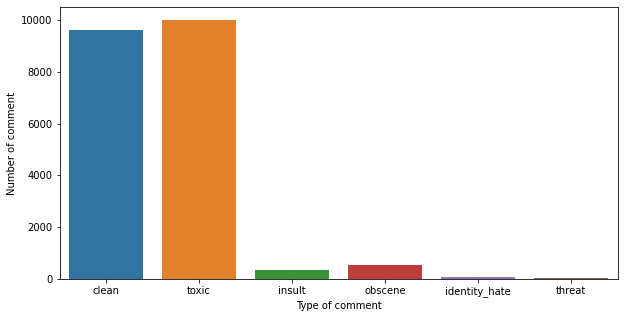

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='comment_type', data=train_data)
plt.xlabel("Type of comment")
plt.ylabel("Number of comment")
plt.show()

In [ ]:
train_data = train_data.fillna(value=np.nan)
train_data = train_data.fillna(value='safe')

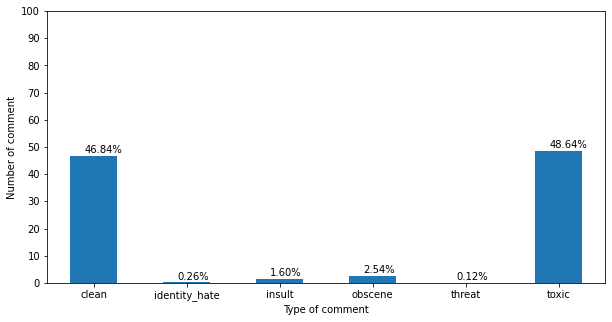

In [ ]:
plt.figure(figsize=(10,5))

ax = (train_data.comment_type.value_counts()/len(train_data)*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
plt.xlabel("Type of comment")
plt.ylabel("Number of comment")
plt.show()

# Menampilkan contoh dari setiap jenis toxic comment

In [ ]:
print('\033[1m' + 'TOXIC' + '\033[0m')
print(train_data['comment_text'][train_data['toxic']==1].iloc[1])
print(' ')

print('******************************************************************')

print('\033[1m' + 'SEVERE TOXIC' + '\033[0m')
print(train_data['comment_text'][train_data['severe_toxic']==1].iloc[1])
print(' ')

print('******************************************************************')

print('\033[1m' + 'OBSCENE' + '\033[0m')
print(train_data['comment_text'][train_data['obscene']==1].iloc[1])
print(' ')

print('******************************************************************')

print('\033[1m' + 'THREAT' + '\033[0m')
print(train_data['comment_text'][train_data['threat']==1].iloc[0])
print(' ')

print('******************************************************************')

print('\033[1m' + 'INSULT' + '\033[0m')
print(train_data['comment_text'][train_data['insult']==1].iloc[1])
print(' ')

print('******************************************************************')

print('\033[1m' + 'IDENTITY HATE' + '\033[0m')
print(train_data['comment_text'][train_data['identity_hate']==1].iloc[1])

TOXIC
omg        

Omg u think your so smart omg!!!!!!!!!!!!!1111
 
******************************************************************
SEVERE TOXIC
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
 
******************************************************************
OBSCENE
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
 
**********************************

# Wordclouds - Frequent words

Sekarang, mari kita lihat kata-kata yang terkait dengan kelas-kelas ini.
Chart Desc : kata-kata yang sering muncul dalam data ini.

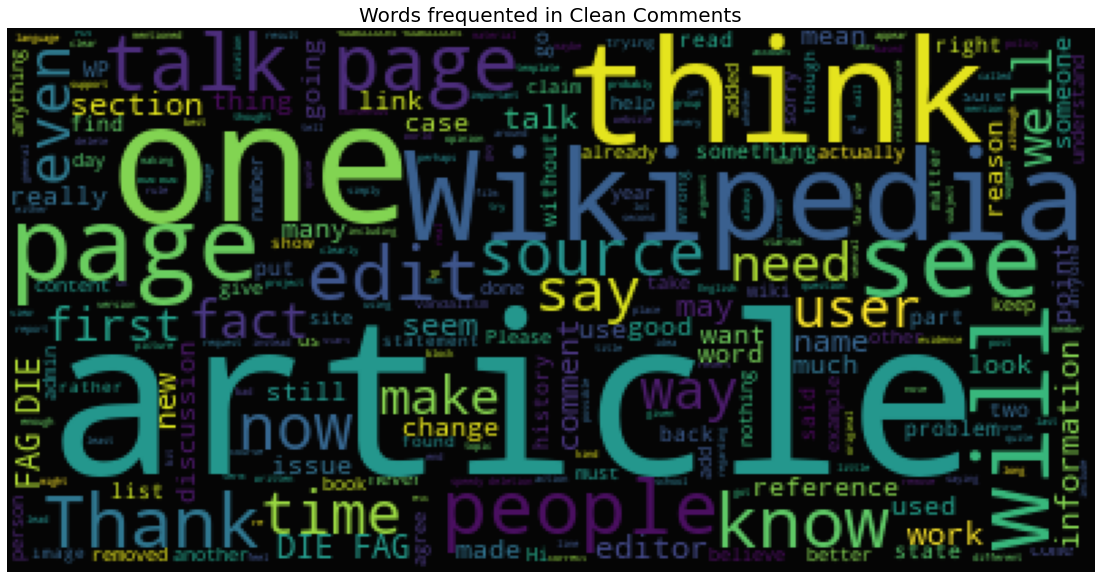

In [ ]:
stopword=set(STOPWORDS)


#wordcloud untuk komen yang sudah dibersihkan
subset=train_data[train_data.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

# Plot Wordcloud sesuai kelas

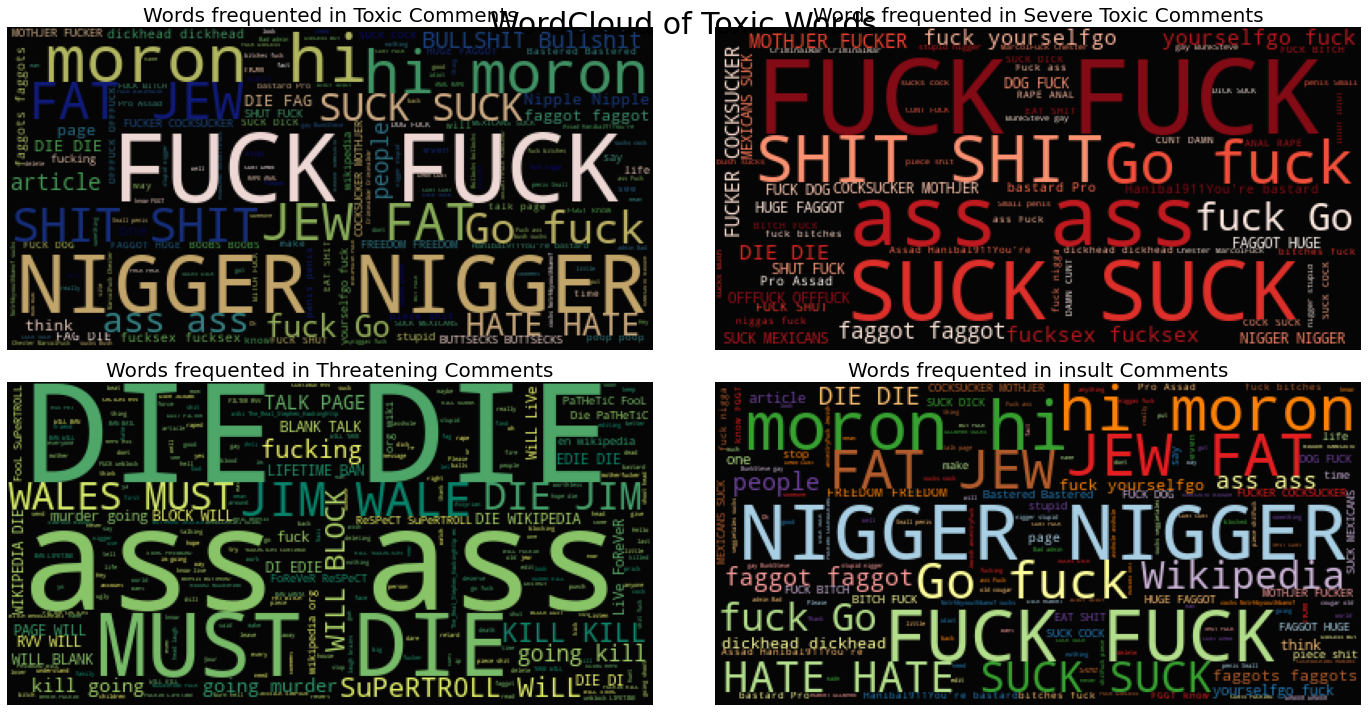

In [ ]:
#wordcloud for clean comments
subset=train_data[train_data.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
subset=train_data[train_data.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
subset=train_data[train_data.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
subset=train_data[train_data.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.suptitle("WordCloud of Toxic Words", fontsize=30)   
plt.tight_layout()
plt.show()

# Perbaiki beberapa singkatan kata

In [ ]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

# Mendefinisikan fungsi untuk membersihkan data

In [ ]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', text) # clean url
    text = re.sub(r'#(\w+)', '', text)   # clean hashes
    text = re.sub(r'@(\w+)', '', text)   # clean @
    text = re.sub(r'<[^>]+>', '', text)  # clean tags
    text = re.sub(r'\d+', '', text)      # clean digits
    text = re.sub(r'[,!@\'\"?\.$%_&#*+-:;]', '', text)   # clean punctuation
    text = [APPO[word] if word in APPO else word for word in text.split()]  #
    
    return text

# Menerapkan fungsi teks bersih untuk melatih dan menguji data

In [ ]:
train_data['comment_text'] = train_data['comment_text'].apply(clean_text)
test_data['comment_text'] = test_data['comment_text'].apply(clean_text)

In [ ]:
train_x = train_data.iloc[:,0]
train_y = train_data.iloc[:,1:7]

train_y = np.array(train_y)

# Split Data menjadi data train dan validation

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y, test_size=0.2, random_state=1)

In [ ]:
tokenizer = Tokenizer(num_words = 100000, oov_token='<oov>')
tokenizer.fit_on_texts(train_data.comment_text)

In [ ]:
traning_sequences = tokenizer.texts_to_sequences(train_x)
maxlen = max([len(x) for x in np.array(traning_sequences)])
training_padded = pad_sequences(traning_sequences, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
validation_sequences = tokenizer.texts_to_sequences(val_x)
validation_padded = pad_sequences(validation_sequences, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

57059

# Gunakan GloVe untuk mempelajari representasi kata

# Import datasetnya 



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
embeddings_index = {}
glovefile = open('/content/gdrive/MyDrive/PACMANN/ASISTENSI/MINGGU 3/glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')

#coefs.shape
    embeddings_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:20, 19783.14it/s]

Found 400000 word vectors.


In [ ]:
#creating embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for words, index in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(words)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

100%|██████████| 57058/57058 [00:00<00:00, 300927.86it/s]


# Membangun bidirectional LSTM model

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim = vocab_size,output_dim = 200,weights = [embedding_matrix],input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='sigmoid')])

In [ ]:
#Summary dari model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1403, 200)         11411800  
                                                                 
 bidirectional (Bidirectiona  (None, 1403, 256)        336896    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 1401, 128)         98432     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0

In [ ]:
#Compile dan jalankan model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(training_padded,train_y, epochs = 1, validation_data=(validation_padded, val_y), batch_size = 32)

514/514 [==============================] - 2227s 4s/step - loss: 0.2251 - accuracy: 0.5738 - val_loss: 0.1911 - val_accuracy: 0.6437


# Predicting on the validation data

In [ ]:
predicted = model.predict(validation_padded)
labels = (predicted > 0.5).astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
def get_toxictype(i,act_or_pred):
    
    l=[]
    count=0
    
    if sum(act_or_pred[:10][i])==0:
        l.append('safe comment')
        
    else:
        for j in range(len(act_or_pred[:10][i])):
            if act_or_pred[:10][i][j]==1 and count == 0:
                l.append('toxic')
            elif act_or_pred[:10][i][j]==1 and count == 1:
                l.append('severe_toxic')
            elif act_or_pred[:10][i][j]==1 and count == 2:
                l.append('obscene')
            elif act_or_pred[:10][i][j]==1 and count == 3:
                l.append('threat')
            elif act_or_pred[:10][i][j]==1 and count == 4:
                l.append('insult')
            elif act_or_pred[:10][i][j]==1 and count == 5:
                l.append('identity_hate')
            
            count=count+1
            
    return l

# Displaying the actual predicted type of comment

In [ ]:
for i,j in enumerate(val_x.index[:10]):
    print('')
    print('\033[1m' + 'Predicted type of comment:' + '\033[0m', get_toxictype(i,labels))
    print('\033[1m' + 'Actual type of comment:' + '\033[0m', get_toxictype(i,val_y))
    print('\033[1m' + 'Comment: ' + '\033[0m',train_data_or.iloc[j,0])
    print('')
    print('****************************************************************************')


Predicted type of comment: ['toxic', 'obscene', 'insult']
Actual type of comment: ['toxic', 'obscene', 'insult']
Comment:  Great, some furfag is undoing my quality opsts. Fuck you!

****************************************************************************

Predicted type of comment: ['safe comment']
Actual type of comment: ['safe comment']
Comment:  "=Update===
Please consult the user talk pages of Gnan/garra and Shell for more discussion between them of this block of me.  I really do not understand how this block is warranted.  I explained that I could not change the archived material in a AN/I because the instructions say not to alter it.  There are plenty of violations of WP:CIVIL and Wikipedia:Etiquette made by others in that AN/I directed against me, yet no one else is being made subject to a block, a ban, other kinds of ""sanctions"" or being asked to delete their comments about me in that archived material.  A retroactive request to delete the record is not something that I 

# Predicting the result on the Test dataset

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(test_data.comment_text)
test_padded = pad_sequences(testing_sequences, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')

In [ ]:
predicted = model.predict(test_padded, batch_size = 200)
predict = np.hstack((test_data.id[:, np.newaxis], predicted))

In [ ]:
subm = pd.DataFrame(predict, columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
subm.to_csv('subm.csv', index = False)